# Entrenando un Clasificador



 - [Visualizador Online de Redes Convolucionales](https://poloclub.github.io/cnn-explainer/)




Generalmente, cuando tienes que trabajar con datos de imágenes, texto, audio o video,
puedes usar paquetes estándar de Python que cargan los datos en un arreglo de numpy.
Luego puedes convertir este arreglo en un `torch.*Tensor`.

-   Para imágenes, paquetes como Pillow y OpenCV son útiles  
-   Para audio, paquetes como scipy y librosa  
-   Para texto, ya sea carga en Python puro o basado en Cython, o NLTK y
    SpaCy son útiles  

Específicamente para visión, hemos creado un paquete llamado `torchvision`,
que tiene cargadores de datos para conjuntos comunes como ImageNet, CIFAR10,
MNIST, etc., y transformadores de datos para imágenes, a saber,
`torchvision.datasets` y `torch.utils.data.DataLoader`.

Esto proporciona una gran comodidad y evita escribir código repetitivo.

Para este tutorial, usaremos el conjunto de datos CIFAR10. Tiene las clases:
'avión', 'automóvil', 'pájaro', 'gato', 'ciervo', 'perro', 'rana', 'caballo',
'barco', 'camión'. Las imágenes en CIFAR-10 son de tamaño 3x32x32, es decir,
imágenes a color de 3 canales con tamaño de 32x32 píxeles.

![cifar10](https://pytorch.org/tutorials/_static/img/cifar10.png)

Entrenando un clasificador de imágenes
--------------------------------------

Haremos los siguientes pasos en orden:

1.  Cargar y normalizar los conjuntos de entrenamiento y prueba de CIFAR10 usando
    `torchvision`  
2.  Definir una Red Neuronal Convolucional  
3.  Definir una función de pérdida  
4.  Entrenar la red con los datos de entrenamiento  
5.  Probar la red con los datos de prueba  

### 1. Cargar y normalizar CIFAR10

Usando `torchvision`, es extremadamente fácil cargar CIFAR10.


In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

La salida de los conjuntos de datos de `torchvision` son imágenes PILImage en el rango [0, 1].  
Las transformamos a Tensores con un rango normalizado de [-1, 1].



In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Mostremos algunas de las imágenes de entrenamiento, por diversión.



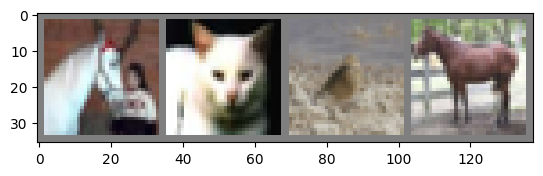

horse cat   bird  horse


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

2. Definir una Red Neuronal Convolucional
=========================================

Copia la red neuronal de la sección de Redes Neuronales anterior y
modifícala para que acepte imágenes de 3 canales (en lugar de imágenes de 1 canal como estaba definida).



In [4]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

3. Definir una función de pérdida y un optimizador
==================================================

Usemos una pérdida de Clasificación de Entropía Cruzada y SGD con momentum.


In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

4. Entrenar la red
==================

Aquí es cuando las cosas comienzan a ponerse interesantes.  
Simplemente tenemos que iterar sobre nuestro iterador de datos, alimentar las entradas a la red y optimizar.


In [6]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.203
[1,  4000] loss: 1.850
[1,  6000] loss: 1.675
[1,  8000] loss: 1.579
[1, 10000] loss: 1.518
[1, 12000] loss: 1.467
[2,  2000] loss: 1.411
[2,  4000] loss: 1.378
[2,  6000] loss: 1.359
[2,  8000] loss: 1.321
[2, 10000] loss: 1.297
[2, 12000] loss: 1.253
Finished Training


Guardemos rápidamente nuestro modelo entrenado:


In [7]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

Consulta [aquí](https://pytorch.org/docs/stable/notes/serialization.html) para
más detalles sobre cómo guardar modelos en PyTorch.

5. Probar la red con los datos de prueba
========================================

Hemos entrenado la red durante 2 pasadas sobre el conjunto de entrenamiento.  
Pero necesitamos comprobar si la red ha aprendido algo en absoluto.

Lo verificaremos prediciendo la etiqueta de clase que la red neuronal
produce y comparándola con la verdad de referencia.  
Si la predicción es correcta, añadimos la muestra a la lista de predicciones correctas.

Bien, primer paso. Mostremos una imagen del conjunto de prueba para familiarizarnos.


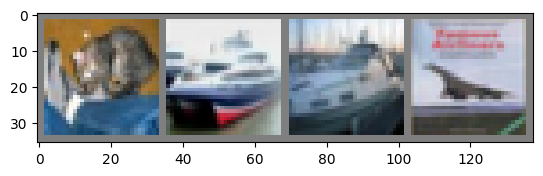

GroundTruth:  cat   ship  ship  plane


In [8]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

Next, let\'s load back in our saved model (note: saving and re-loading
the model wasn\'t necessary here, we only did it to illustrate how to do
so):


In [9]:
net = Net()
net.load_state_dict(torch.load(PATH, weights_only=True))

<All keys matched successfully>

Okay, now let us see what the neural network thinks these examples above
are:


In [10]:
outputs = net(images)

The outputs are energies for the 10 classes. The higher the energy for a
class, the more the network thinks that the image is of the particular
class. So, let\'s get the index of the highest energy:


In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   car   car   plane


The results seem pretty good.

Let us look at how the network performs on the whole dataset.


In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

That looks way better than chance, which is 10% accuracy (randomly
picking a class out of 10 classes). Seems like the network learnt
something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:


In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')